1. Crie uma MLP genérica para modelo de classificação binária (ou não) implementando forward, backward e loss.
    
    a. É necessário que o usuário possa definir quantas layers e neurônios desejar
    
    b. É necessário que a loss utilizada seja binary cross-entropy (estude um pouco mais sobre esse tópico)
    
    c. É necessário que a rede funcione para diferentes datasets de classificação, considerando que o dado de entrada para o modelo já esteja no formato desejado, como por exemplo número de features, target binário.
    
    d. É necessário que a  função de ativação da layer de output retorne uma probabilidade (entre 0 e 1), então use algo como sigmoid por exemplo.
    
    e. A regra de update dos pesos pode ser feita utilizando a regra básica do gradient descent (weight = weight - learning_rate * gradient)
2. (Opcional - Difícil 1) Crie uma MLP para classificar o dataset MNIST e faça as adaptações necessárias
3. (Opcional - Difícil 2) Crie um otimizador para update dos pesos utilizando o gradient e learning_rate. Como por exemplo, o otimizador Adam.
As informações da aula de hoje estão dentro do repositório de lectures/users/luisa/NN/XOR-zero.ipynb. Se precisarem das informações escritas posso emprestar meus rascunhos.


Defining generic Layer class

In [364]:
import numpy as np
import math

class NetOperation():

  def forward():
    pass

  def backward():
    pass

  def optimize():
    pass

class Layer(NetOperation):
  def __init__(self, n_in: int, n_out: int):
    self.weights = np.random.randn(n_in, n_out) * 0.01
    self.bias = np.zeros(shape=(1, n_out))

  # z = a1w1 + a2w2 + a3w3 + ... + b
  def forward(self, a):
    self.a = a
    return a.dot(self.weights) + self.bias

  # dgrad = dL / z
  # dL / dwi = dL / dz * dz / dwi
  def backward(self, grad):
    print(f'Layer backward grad received: {grad}')
    self.grad_weights = self.a.T.dot(grad)
    self.grad_bias = np.mean(grad, axis= 0)
    # DUVIDA PRIMORDIAL (PRECISO VER ISSO, NÃO ENTENDI MUITO BEM)
    # peguei do código da luiza a ideia
    return grad.dot(self.weights.T)

  def optimize(self, learning_rate):
    print(f'Doing optimization with: {self.grad_weights}')
    self.weights -= self.grad_weights * learning_rate
    self.grad_weights = None

    self.bias -= self.grad_bias * learning_rate
    self.grad_bias = None

class ReLU(NetOperation):
  # a: activation
  # z: weighted sum

  # a = f(z)
  def f(self, z):
    return np.maximum(0, z)
  
  # da / dz
  # a = df(z)
  def df(self, z):
    return np.greater(0, z).astype(int)

  def forward(self, z):
    self.z = z
    return self.f(z)
  
  # dgrad = dL / da
  # dL / dz = da / dz * dL / da
  def backward(self, grad):
    return self.df(self.z) * grad

  def optimize(*args, **kwargs):
    pass
  
class Sigmoid(NetOperation):
  # a: activation
  # z: weighted sum

  def f(self, z):
    return 1 / (1 + np.exp(-z))
  
  def df(self, z):
    s = self.f(z)
    return s * (1 - s)

  def forward(self, z):
    self.z = z
    return self.f(z)
  
  def backward(self, grad):
    return self.df(self.z) * grad

  def optimize(*args, **kwargs):
    pass
    

In [365]:
class MLP(NetOperation):
  layers: list[NetOperation]

  def __init__(self, n_features: int, neurons_per_layer: list[int]):
    input_layer = [Layer(n_features, neurons_per_layer[0])]
    hidden_layers = []

    for i in range(len(neurons_per_layer) - 1):
    
      hidden_layers.extend([ReLU(), Layer(neurons_per_layer[i], neurons_per_layer[i + 1])])


    self.layers = input_layer + hidden_layers + [Sigmoid()]


  def forward(self, x):
    activation = x

    for layer in self.layers:
      activation = layer.forward(activation)

    return activation
  
  # [Sigmoid(), Layer, ReLU, Layer, ReLU, Layer]
  # propagate error
  def backward(self, grad):
    self.layers.reverse()
    
    for layer in self.layers:
      grad = layer.backward(grad)

    self.layers.reverse()

  def optimize(self, learning_rate):
    for i, layer in enumerate(self.layers):
      if hasattr(layer, 'weights'):
        print(f"Layer {i} weights before optimize:")
        print(layer.weights)
      layer.optimize(learning_rate)
      if hasattr(layer, 'weights'):
        print(f"Layer {i} weights after optimize:")
        print(layer.weights)

Train

Epoch 0
predictions: [[0.5       ]
 [0.50004939]
 [0.5       ]
 [0.5000165 ]]
target_samples: [[0]
 [1]
 [1]
 [0]]
error: [[0.1732868 ]
 [0.1732621 ]
 [0.1732868 ]
 [0.17329504]]
d_bce_loss: [[ 2.        ]
 [-1.99980246]
 [-2.        ]
 [ 2.00006599]]
Layer backward grad received: [[ 0.5       ]
 [-0.49995061]
 [-0.5       ]
 [ 0.5000165 ]]
Layer backward grad received: [[-0.          0.        ]
 [ 0.0066242  -0.        ]
 [ 0.00662485 -0.00657003]
 [-0.00662507  0.        ]]
Layer 0 weights before optimize:
[[-0.00280319 -0.01001295]
 [-0.02416262  0.01503461]]
Doing optimization with: [[-2.18570258e-07 -6.57003356e-03]
 [-8.72958973e-07  0.00000000e+00]]
Layer 0 weights after optimize:
[[-0.00280057  0.06882746]
 [-0.02415215  0.01503461]]
Layer 2 weights before optimize:
[[-0.0132497 ]
 [ 0.01314007]]
Doing optimization with: [[ 0.        ]
 [-0.00500565]]
Layer 2 weights after optimize:
[[-0.0132497 ]
 [ 0.07320785]]
Accuracy: [[0.25]
 [0.25]
 [0.  ]
 [0.  ]]
Epoch 1
predictions: 

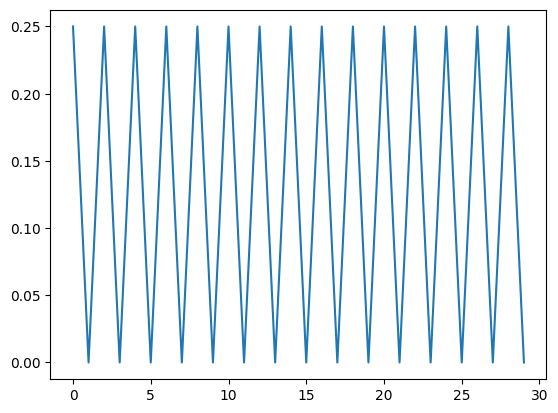

In [366]:
from matplotlib import pyplot as plt

# https://towardsdatascience.com/nothing-but-numpy-understanding-creating-binary-classification-neural-networks-with-e746423c8d5c
def BCELoss(prediction, target):
  n = len(target)
  return - 1 / n * (target * np.log(prediction) + (1 - target) * np.log(1 - prediction))

def dBCELoss(prediction, target):
  return - target / prediction + (1 - target) / (1 - prediction)


X = np.array([
  [0, 0],
  [0, 1],
  [1, 0],
  [1, 1],
])
Y = np.array([
  [0],
  [1],
  [1],
  [0]
])

net = MLP(2, [2, 1])

learning_rate = 12
batch_size = 4
xs = range(30)
accuracies = []
for epoch in xs:
  print(f'Epoch {epoch}')
  hits = 0
  for i in range(0, len(X), batch_size):
    train_samples = X[i : i + batch_size]
    target_samples = Y[i : i + batch_size]


    predictions = net.forward(train_samples)
    print(f'predictions: {predictions}')
    print(f'target_samples: {target_samples}')
    error = BCELoss(predictions, target_samples)
    d_bce_loss = dBCELoss(predictions, target_samples)
    print(f'error: {error}')
    print(f'd_bce_loss: {d_bce_loss}')
    net.backward(d_bce_loss)
    net.optimize(learning_rate)

    hits += (predictions > 0.5) == target_samples

  accuracies.append((hits / len(X)).reshape(-1)[0])

  print(f'Accuracy: {hits / len(X)}')
plt.plot(xs, accuracies)

Test

In [367]:
hits = 0
for i in range(len(test['data'])):
  test_sample = test['data'][i].reshape(1, 4)
  target_sample = test['target'][i]

  prediction = layer.forward(test_sample)
  prediction = prediction >= 0.5

  hits += prediction == target_sample
print('Accuracy: ', hits/len(test['data']))

NameError: name 'test' is not defined